## Packages setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os, glob, time
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from scipy.spatial import distance_matrix
from tqdm import tqdm
import matplotlib.pyplot as plt

Mounted at /content/drive


## Parameters setup

In [ ]:
test_iter = '/06'     # test iteration, use to create folder

# Hyperparameters
NB_EPOCHS         = 100
BATCH_SIZE        = 50
NB_BINS           = 928
EMBEDDING_SIZE    = 3
LEARNING_RATE     = 0.0025
SEED              = 42
PATIENCE          = 15
SAVE_INTERVAL     = 10       # epochs
ALPHA             = 1.25     # Hi‑C exponent

NOISE_VARIANCE = 0.05   # small coordinate noise to break symmetry

# amount of data used for training and test
NB_STRUCTURES_TRAINING = 5400
NB_STRUCTURES_TESTING = 600

# size of training and test set
TRAIN_SIZE = 9000
TRAIN_SIZE = min(TRAIN_SIZE, NB_STRUCTURES_TRAINING)
TEST_SIZE  = 1000
TEST_SIZE  = min(TEST_SIZE, NB_STRUCTURES_TESTING)

# path to save model
CHECKPOINT_DIR    = '/content/drive/MyDrive/STATS507/TECH3D/model/checkpoints'
CHECKPOINT_DIR = CHECKPOINT_DIR + test_iter
BEST_MODEL_PATH   = os.path.join(CHECKPOINT_DIR, 'best_model.pt')

# random seed
torch.manual_seed(SEED)
np.random.seed(SEED)
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

## Data Loader

In [ ]:
from sklearn.preprocessing import MinMaxScaler

class SyntheticChromosomeDataset(Dataset):
    def __init__(self, struct_paths, alpha):
        self.struct_paths = struct_paths
        self.alpha        = alpha

    def __len__(self):
        return len(self.struct_paths)

    def __getitem__(self, idx):
        struct = np.load(self.struct_paths[idx], mmap_mode='r').astype(np.float32)         # [NB_BINS,3]
        dist   = distance_matrix(struct, struct).astype(np.float32)                       # [NB_BINS,NB_BINS]

        dnz    = np.where(dist == 0, np.inf, dist)
        hic    = np.where(dnz == np.inf, 0.0, np.power(dnz, -self.alpha)).astype(np.float32)
        scaler = MinMaxScaler()
        hic = scaler.fit_transform(hic)


        return {
            'struct': torch.from_numpy(struct).unsqueeze(0),  # [1,NB_BINS,3]
            'dist':   torch.from_numpy(dist).unsqueeze(0),    # [1,NB_BINS,NB_BINS]
            'hic':    torch.from_numpy(hic).unsqueeze(0),     # [1,NB_BINS,NB_BINS]
        }

# build dataloaders
base_dir    = '/content/drive/MyDrive/STATS507/TECH3D'
train_paths = sorted(glob.glob(os.path.join(base_dir, 'train/structure_matrices','*.npy')))
train_paths = train_paths[:TRAIN_SIZE]
test_paths  = sorted(glob.glob(os.path.join(base_dir, 'test/structure_matrices', '*.npy')))
test_paths  = test_paths[:TEST_SIZE]

train_loader = DataLoader(
    SyntheticChromosomeDataset(train_paths, alpha=ALPHA),
    batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)

test_loader = DataLoader(
    SyntheticChromosomeDataset(test_paths,  alpha=ALPHA),
    batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)


## Check structure and hic loaded

In [ ]:
for batch_idx, batch in enumerate(train_loader):
    struct = batch['struct']  # [B,1,NB_BINS,3]
    hic    = batch['hic']     # [B,1,NB_BINS,NB_BINS]

    print(f"Batch {batch_idx}:")
    print("  struct shape:", struct.shape)
    print("  first sample struct coords (first 5 bins):")
    print(struct[0, 0, :5, :])  # first 5 bins of the first sample

    print("  hic shape:", hic.shape)
    print("  first sample hic stats: min =", hic[0,0].min().item(),
          ", max =", hic[0,0].max().item(),
          ", mean =", hic[0,0].mean().item())
    print()

    hic = batch['hic'][0, 0].numpy()

    plt.figure(figsize=(6, 6))
    plt.imshow(hic, cmap='hot')
    plt.title('Hi‑C Contact Map (First Sample)')
    plt.xlabel('Bin index')
    plt.ylabel('Bin index')
    plt.colorbar(label='Contact intensity')
    plt.show()

    break

## centralizaiton and normalization

In [ ]:
def centralize_torch(z):
    return z - torch.mean(z, dim=1, keepdim=True)

def normalize_torch(z):
    norms = torch.norm(z, p=2, dim=2, keepdim=True)            # [B,NB_BINS,1]
    return z / (norms + 1e-8)

def centralize_and_normalize_torch(z):
    return normalize_torch(centralize_torch(z))

## Model Definition

In [ ]:

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.lstm_encoder = nn.LSTM(
            input_size=NB_BINS,
            hidden_size=EMBEDDING_SIZE,
            batch_first=True,
            bidirectional=True
        )
        self.nn_encoder   = nn.Linear(2*EMBEDDING_SIZE, EMBEDDING_SIZE)
        self.noise_variance = NOISE_VARIANCE
        self.xavier_initializer(self.lstm_encoder)
        self.xavier_initializer(self.nn_encoder)

    def forward(self, x):
        # remove channel dim if present
        if x.dim()==4: x = x.squeeze(1)               # [B,NB_BINS,NB_BINS]
        out, _ = self.lstm_encoder(x)                  # [B,NB_BINS,2E]
        z       = self.nn_encoder(out)                 # [B,NB_BINS,E]
        z       = centralize_and_normalize_torch(z)    # normalized coords
        # z       = centralize_torch(z)    # normalized coords

        # --- NEW: add small Gaussian noise during training ---
        if self.training and self.noise_variance > 0:
            z = z + torch.randn_like(z) * self.noise_variance

        # reconstruct distances
        w = torch.cdist(z, z, p=2)                     # [B,NB_BINS,NB_BINS]
        return z, w

    def xavier_initializer(self, module):
        for name, param in module.named_parameters():
            if 'weight' in name: nn.init.xavier_normal_(param)
            elif 'bias' in name: nn.init.constant_(param, 0.0)




## Loss Functions & Evaluate

In [ ]:
# biological smoothness
def biological_loss_fct(ps, pd, eps=1e-8):
    # 0) nuke any inf/nan in pd
    pd = torch.nan_to_num(pd, nan=0.0, posinf=1e12, neginf=-1e12)
    # per‐bin distances variance
    bdist = torch.diagonal(pd, offset=1, dim1=1, dim2=2)
    l_d   = torch.var(bdist)

    # angle smoothness
    vecs = ps[:,1:,:] - ps[:,:-1,:]           # [B, N‑1, 3]
    v1, v2 = vecs[:,:-1,:], vecs[:,1:,:]      # [B, N‑2, 3]
    dotp    = (v1 * v2).sum(dim=2)            # [B, N‑2]
    n1      = torch.norm(v1, p=2, dim=2).clamp(min=eps)
    n2      = torch.norm(v2, p=2, dim=2).clamp(min=eps)
    cosang  = dotp / (n1 * n2)
    cosang  = cosang.clamp(-1+eps, 1-eps)     # keep it in [-1,1]
    l_a     = torch.nan_to_num((1 - cosang).mean(), nan=0.0)

    return l_d + l_a

# kabsch rotation
def kabsch_loss_fct(ps, ts):
    # center
    p_cent = ps - ps.mean(1, keepdim=True)
    t_cent = ts - ts.mean(1, keepdim=True)

    # covariance
    H = torch.nan_to_num(p_cent.transpose(1,2) @ t_cent,
                         nan=0.0, posinf=1e12, neginf=-1e12)

    # batched SVD
    U, S, Vh = torch.linalg.svd(H, full_matrices=False)
    V = Vh.transpose(-2, -1)
    Ut = U.transpose(-2, -1)

    # reflection fix
    dets = torch.linalg.det(V @ Ut)
    D = torch.eye(EMBEDDING_SIZE, device=H.device) \
            .unsqueeze(0).repeat(ps.size(0),1,1)
    D[:, -1, -1] = torch.sign(dets)

    # proper rotation
    R = V @ D @ Ut

    # align & clamp
    p_align = torch.nan_to_num(p_cent @ R, nan=0.0, posinf=1e12, neginf=-1e12)

    # final MSE
    return torch.mean(torch.sum((p_align - t_cent).pow(2), dim=2))

# distance correlation
# Rotation‑ and translation‑invariant loss based on Pearson correlation
# between predicted vs. true pairwise distance vectors
def structure_correlation_loss(ps: torch.Tensor,
                               ts: torch.Tensor,
                               eps: float = 1e-8) -> torch.Tensor:


    B, N, _ = ps.shape

    # Compute pairwise distances
    pdist = torch.cdist(ps, ps, p=2)  # [B, N, N]
    tdist = torch.cdist(ts, ts, p=2)  # [B, N, N]

    # Flatten and mask out the diagonal
    # Create a flattened mask of length N*N with False on diagonal
    diag_mask = ~torch.eye(N, device=ps.device, dtype=torch.bool).view(-1)  # [N*N]

    # Reshape distances to [B, N*N] and apply mask → [B, N*(N-1)]
    p_flat = pdist.view(B, N*N)
    t_flat = tdist.view(B, N*N)
    pd = p_flat[:, diag_mask]
    td = t_flat[:, diag_mask]

    # Zero‑center each vector
    pd = pd - pd.mean(dim=1, keepdim=True)
    td = td - td.mean(dim=1, keepdim=True)

    # Compute Pearson correlation per sample
    num = (pd * td).sum(dim=1)                                    # [B]
    den = torch.sqrt((pd.pow(2).sum(dim=1) * td.pow(2).sum(dim=1)) + eps)  # [B]
    r   = num / (den + eps)                                       # [B]

    # Loss = mean(1 – r)
    return torch.mean(1.0 - r)


# distance loss
distance_loss_fct = nn.MSELoss()

def evaluate(loader, model, device):
    model.eval()
    bio_losses, struc_losses, dist_losses = [], [], []
    with torch.no_grad():
        for batch in loader:
            hic = batch['hic'].to(device)
            ts  = batch['struct'].squeeze(1).to(device)
            td  = batch['dist'].squeeze(1).to(device)

            ps, pd = model(hic)
            bio_losses.append(biological_loss_fct(ps, pd).item())
            # kab_losses.append(kabsch_loss_fct(ps, ts).item())
            struc_losses.append(structure_correlation_loss(ps, ts).item())
            dist_losses.append(distance_loss_fct(torch.nan_to_num(pd,nan=0.0,posinf=1e6,neginf=-1e6),
                                                 torch.nan_to_num(td,nan=0.0,posinf=1e6,neginf=-1e6)).item())


    return (
        np.mean(bio_losses),
        np.mean(struc_losses),
        np.mean(dist_losses)
    )


## Prepare Model, Optimizer and Scheduler

In [ ]:
device    = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model     = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
# adptive learning rate
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.8)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer, mode='min', factor=0.5, patience=3)

## Training Loop with progres bar, Saving, Logging, Live Plot

Training epochs:   1%|          | 1/100 [11:31<19:01:13, 691.65s/it]

Epoch 001 | Train B: 1.3466 S: 0.1399 D: 0.1706 | Test  B: 1.3473 S: 0.1364 D: 0.1669 | ✔️ Improved | Time: 691.7s


Training epochs:   2%|▏         | 2/100 [17:15<13:15:21, 486.96s/it]

Epoch 002 | Train B: 1.3417 S: 0.1247 D: 0.1377 | Test  B: 1.3426 S: 0.1208 D: 0.1368 | ✔️ Improved | Time: 343.7s


Training epochs:   3%|▎         | 3/100 [22:53<11:17:13, 418.90s/it]

Epoch 003 | Train B: 1.3477 S: 0.1085 D: 0.1339 | Test  B: 1.3485 S: 0.1028 D: 0.1331 | ✔️ Improved | Time: 337.9s


Training epochs:   4%|▍         | 4/100 [28:32<10:20:00, 387.51s/it]

Epoch 004 | Train B: 1.3310 S: 0.0896 D: 0.0690 | Test  B: 1.3326 S: 0.0849 D: 0.0693 | ✔️ Improved | Time: 339.4s


Training epochs:   5%|▌         | 5/100 [34:16<9:48:25, 371.64s/it] 

Epoch 005 | Train B: 1.3146 S: 0.0838 D: 0.0649 | Test  B: 1.3162 S: 0.0792 D: 0.0652 | ✔️ Improved | Time: 343.5s


Training epochs:   6%|▌         | 6/100 [39:55<9:25:18, 360.84s/it]

Epoch 006 | Train B: 1.3018 S: 0.0795 D: 0.0595 | Test  B: 1.3032 S: 0.0750 D: 0.0598 | ✔️ Improved | Time: 339.9s


Training epochs:   7%|▋         | 7/100 [45:33<9:07:33, 353.27s/it]

Epoch 007 | Train B: 1.2996 S: 0.0772 D: 0.0559 | Test  B: 1.3008 S: 0.0726 D: 0.0560 | ✔️ Improved | Time: 337.7s


Training epochs:   8%|▊         | 8/100 [51:12<8:54:23, 348.52s/it]

Epoch 008 | Train B: 1.3025 S: 0.0761 D: 0.0430 | Test  B: 1.2989 S: 0.0715 D: 0.0429 | ✔️ Improved | Time: 338.3s


Training epochs:   9%|▉         | 9/100 [56:56<8:46:38, 347.24s/it]

Epoch 009 | Train B: 1.2947 S: 0.0748 D: 0.0481 | Test  B: 1.2958 S: 0.0702 D: 0.0478 | ✔️ Improved | Time: 344.4s
Epoch 010 | Train B: 1.2961 S: 0.0753 D: 0.0391 | Test  B: 1.2971 S: 0.0708 D: 0.0388 | ✔️ Improved | Time: 334.6s


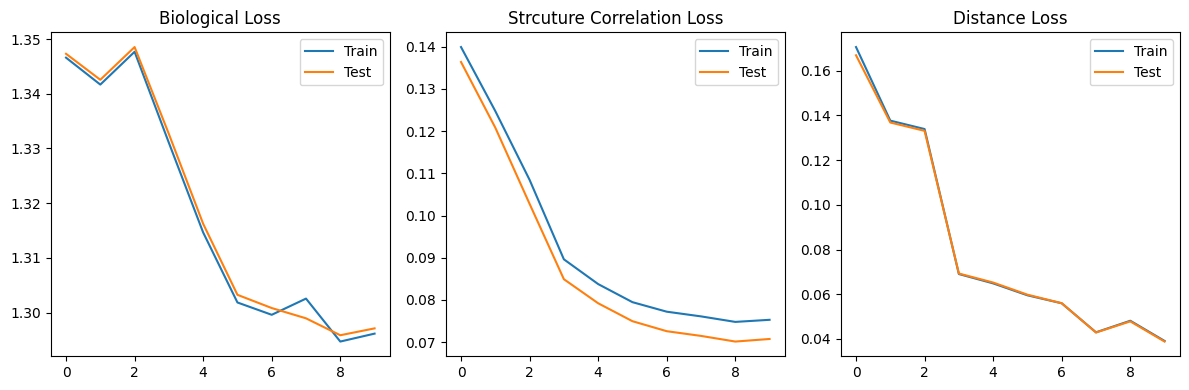

Training epochs:  11%|█         | 11/100 [1:08:16<8:30:16, 344.00s/it]

Epoch 011 | Train B: 1.2964 S: 0.0723 D: 0.0434 | Test  B: 1.2973 S: 0.0676 D: 0.0429 | ✔️ Improved | Time: 345.2s


Training epochs:  12%|█▏        | 12/100 [1:14:05<8:26:31, 345.36s/it]

Epoch 012 | Train B: 1.2967 S: 0.0722 D: 0.0354 | Test  B: 1.2979 S: 0.0676 D: 0.0348 | ✔️ Improved | Time: 348.5s


Training epochs:  13%|█▎        | 13/100 [1:19:50<8:20:56, 345.48s/it]

Epoch 013 | Train B: 1.2982 S: 0.0707 D: 0.0390 | Test  B: 1.2992 S: 0.0661 D: 0.0383 | ✔️ Improved | Time: 345.8s


Training epochs:  14%|█▍        | 14/100 [1:25:34<8:14:33, 345.04s/it]

Epoch 014 | Train B: 1.2980 S: 0.0724 D: 0.0341 | Test  B: 1.2993 S: 0.0677 D: 0.0334 |  | Time: 344.0s


Training epochs:  15%|█▌        | 15/100 [1:31:19<8:08:26, 344.78s/it]

Epoch 015 | Train B: 1.2988 S: 0.0717 D: 0.0331 | Test  B: 1.2997 S: 0.0670 D: 0.0324 | ✔️ Improved | Time: 344.2s


Training epochs:  16%|█▌        | 16/100 [1:37:04<8:03:05, 345.07s/it]

Epoch 016 | Train B: 1.2985 S: 0.0696 D: 0.0349 | Test  B: 1.2991 S: 0.0650 D: 0.0342 | ✔️ Improved | Time: 345.7s


Training epochs:  17%|█▋        | 17/100 [1:42:48<7:56:33, 344.50s/it]

Epoch 017 | Train B: 1.2982 S: 0.0699 D: 0.0338 | Test  B: 1.2990 S: 0.0653 D: 0.0332 |  | Time: 343.2s


Training epochs:  18%|█▊        | 18/100 [1:48:29<7:49:35, 343.60s/it]

Epoch 018 | Train B: 1.2963 S: 0.0692 D: 0.0349 | Test  B: 1.2973 S: 0.0645 D: 0.0343 | ✔️ Improved | Time: 341.5s


Training epochs:  19%|█▉        | 19/100 [1:54:12<7:43:37, 343.43s/it]

Epoch 019 | Train B: 1.2969 S: 0.0688 D: 0.0347 | Test  B: 1.2980 S: 0.0642 D: 0.0341 | ✔️ Improved | Time: 343.0s
Epoch 020 | Train B: 1.2985 S: 0.0696 D: 0.0348 | Test  B: 1.2989 S: 0.0649 D: 0.0341 |  | Time: 342.5s


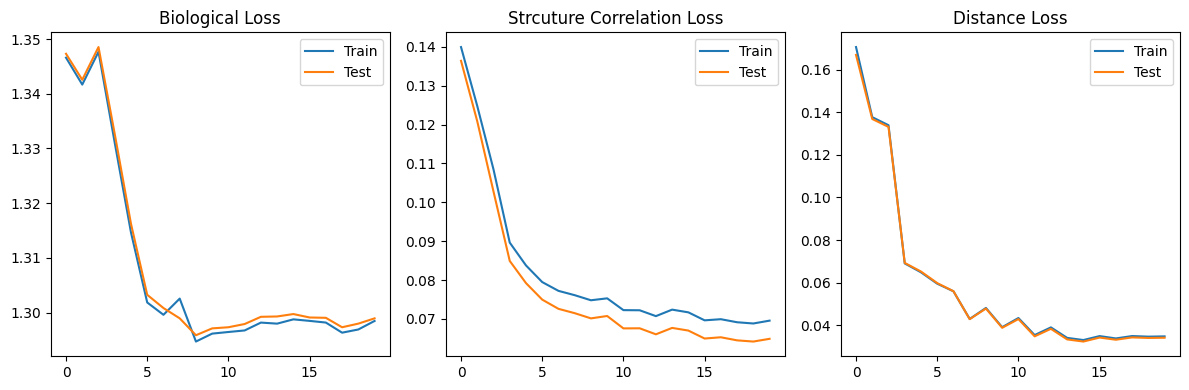

Training epochs:  21%|██        | 21/100 [2:05:38<7:31:43, 343.08s/it]

Epoch 021 | Train B: 1.2989 S: 0.0686 D: 0.0330 | Test  B: 1.2995 S: 0.0639 D: 0.0323 | ✔️ Improved | Time: 342.5s


Training epochs:  22%|██▏       | 22/100 [2:11:18<7:25:03, 342.36s/it]

Epoch 022 | Train B: 1.2977 S: 0.0684 D: 0.0310 | Test  B: 1.2986 S: 0.0637 D: 0.0304 | ✔️ Improved | Time: 340.7s


Training epochs:  23%|██▎       | 23/100 [2:16:59<7:18:51, 341.96s/it]

Epoch 023 | Train B: 1.2982 S: 0.0679 D: 0.0329 | Test  B: 1.2991 S: 0.0632 D: 0.0322 | ✔️ Improved | Time: 341.0s


Training epochs:  24%|██▍       | 24/100 [2:22:40<7:12:44, 341.64s/it]

Epoch 024 | Train B: 1.2971 S: 0.0683 D: 0.0338 | Test  B: 1.2978 S: 0.0636 D: 0.0332 |  | Time: 340.9s


Training epochs:  25%|██▌       | 25/100 [2:28:21<7:06:45, 341.41s/it]

Epoch 025 | Train B: 1.2977 S: 0.0679 D: 0.0346 | Test  B: 1.2987 S: 0.0632 D: 0.0339 |  | Time: 340.9s


Training epochs:  26%|██▌       | 26/100 [2:34:03<7:01:15, 341.56s/it]

Epoch 026 | Train B: 1.2984 S: 0.0678 D: 0.0326 | Test  B: 1.2989 S: 0.0630 D: 0.0319 | ✔️ Improved | Time: 341.9s


Training epochs:  27%|██▋       | 27/100 [2:39:44<6:55:24, 341.43s/it]

Epoch 027 | Train B: 1.2966 S: 0.0683 D: 0.0338 | Test  B: 1.2973 S: 0.0636 D: 0.0332 |  | Time: 341.1s


Training epochs:  28%|██▊       | 28/100 [2:45:24<6:49:17, 341.07s/it]

Epoch 028 | Train B: 1.2956 S: 0.0674 D: 0.0341 | Test  B: 1.2961 S: 0.0627 D: 0.0335 | ✔️ Improved | Time: 340.3s


Training epochs:  29%|██▉       | 29/100 [2:51:06<6:43:45, 341.20s/it]

Epoch 029 | Train B: 1.2982 S: 0.0672 D: 0.0327 | Test  B: 1.2988 S: 0.0625 D: 0.0321 | ✔️ Improved | Time: 341.5s
Epoch 030 | Train B: 1.2971 S: 0.0679 D: 0.0303 | Test  B: 1.2977 S: 0.0631 D: 0.0296 | ✔️ Improved | Time: 341.5s


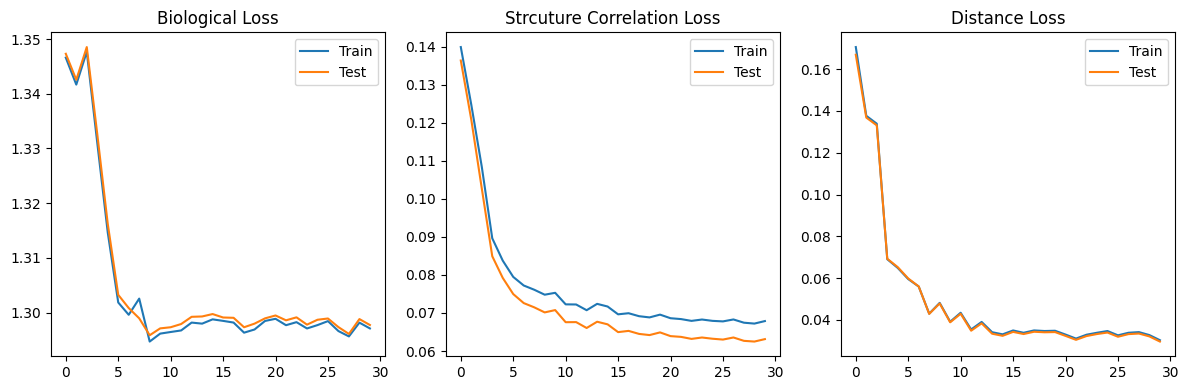

Training epochs:  31%|███       | 31/100 [3:02:29<6:32:38, 341.43s/it]

Epoch 031 | Train B: 1.2975 S: 0.0674 D: 0.0290 | Test  B: 1.2986 S: 0.0626 D: 0.0284 | ✔️ Improved | Time: 341.5s


Training epochs:  32%|███▏      | 32/100 [3:08:10<6:26:34, 341.09s/it]

Epoch 032 | Train B: 1.2967 S: 0.0671 D: 0.0309 | Test  B: 1.2975 S: 0.0624 D: 0.0303 | ✔️ Improved | Time: 340.3s


Training epochs:  33%|███▎      | 33/100 [3:13:49<6:20:21, 340.61s/it]

Epoch 033 | Train B: 1.2970 S: 0.0674 D: 0.0322 | Test  B: 1.2980 S: 0.0626 D: 0.0317 |  | Time: 339.5s


Training epochs:  34%|███▍      | 34/100 [3:19:28<6:14:15, 340.23s/it]

Epoch 034 | Train B: 1.2972 S: 0.0677 D: 0.0300 | Test  B: 1.2982 S: 0.0629 D: 0.0294 |  | Time: 339.3s


Training epochs:  35%|███▌      | 35/100 [3:25:09<6:08:45, 340.40s/it]

Epoch 035 | Train B: 1.2969 S: 0.0672 D: 0.0292 | Test  B: 1.2977 S: 0.0624 D: 0.0286 | ✔️ Improved | Time: 340.8s


Training epochs:  36%|███▌      | 36/100 [3:30:49<6:02:59, 340.30s/it]

Epoch 036 | Train B: 1.2952 S: 0.0668 D: 0.0293 | Test  B: 1.2962 S: 0.0620 D: 0.0288 | ✔️ Improved | Time: 340.1s


Training epochs:  37%|███▋      | 37/100 [3:36:31<5:57:38, 340.62s/it]

Epoch 037 | Train B: 1.2953 S: 0.0667 D: 0.0328 | Test  B: 1.2961 S: 0.0620 D: 0.0323 |  | Time: 341.4s


Training epochs:  38%|███▊      | 38/100 [3:42:11<5:51:56, 340.58s/it]

Epoch 038 | Train B: 1.2950 S: 0.0666 D: 0.0311 | Test  B: 1.2960 S: 0.0618 D: 0.0306 |  | Time: 340.5s


Training epochs:  39%|███▉      | 39/100 [3:47:52<5:46:22, 340.69s/it]

Epoch 039 | Train B: 1.2956 S: 0.0671 D: 0.0287 | Test  B: 1.2968 S: 0.0623 D: 0.0280 |  | Time: 340.9s
Epoch 040 | Train B: 1.2965 S: 0.0664 D: 0.0317 | Test  B: 1.2975 S: 0.0616 D: 0.0311 |  | Time: 339.0s


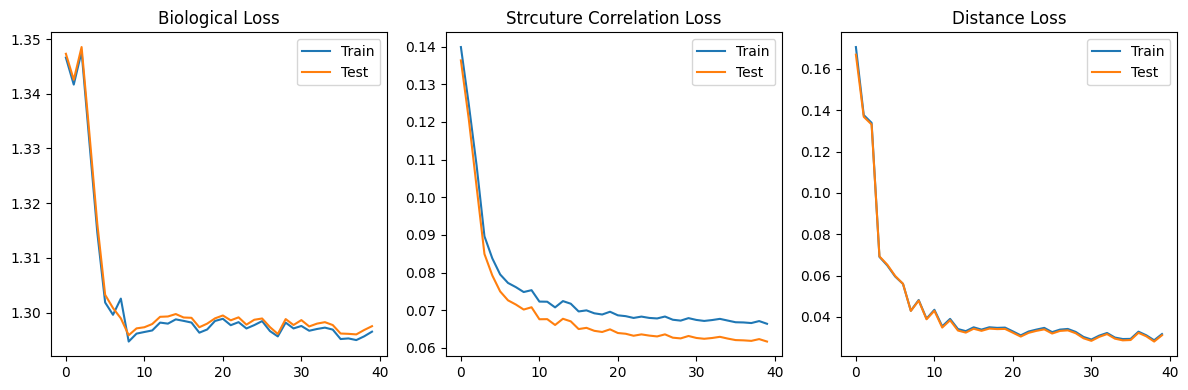

Training epochs:  41%|████      | 41/100 [3:59:10<5:34:15, 339.92s/it]

Epoch 041 | Train B: 1.2948 S: 0.0662 D: 0.0300 | Test  B: 1.2960 S: 0.0614 D: 0.0294 | ✔️ Improved | Time: 339.1s


Training epochs:  42%|████▏     | 42/100 [4:04:49<5:28:12, 339.53s/it]

Epoch 042 | Train B: 1.2942 S: 0.0663 D: 0.0298 | Test  B: 1.2952 S: 0.0615 D: 0.0293 | ✔️ Improved | Time: 338.6s


Training epochs:  43%|████▎     | 43/100 [4:10:30<5:22:57, 339.95s/it]

Epoch 043 | Train B: 1.2952 S: 0.0661 D: 0.0311 | Test  B: 1.2963 S: 0.0614 D: 0.0306 |  | Time: 340.9s


Training epochs:  44%|████▍     | 44/100 [4:16:10<5:17:19, 339.99s/it]

Epoch 044 | Train B: 1.2946 S: 0.0659 D: 0.0309 | Test  B: 1.2956 S: 0.0612 D: 0.0304 | ✔️ Improved | Time: 340.1s


Training epochs:  45%|████▌     | 45/100 [4:21:51<5:11:48, 340.15s/it]

Epoch 045 | Train B: 1.2925 S: 0.0658 D: 0.0296 | Test  B: 1.2933 S: 0.0610 D: 0.0291 | ✔️ Improved | Time: 340.5s


Training epochs:  46%|████▌     | 46/100 [4:27:31<5:06:15, 340.29s/it]

Epoch 046 | Train B: 1.2949 S: 0.0662 D: 0.0294 | Test  B: 1.2961 S: 0.0614 D: 0.0289 |  | Time: 340.6s


Training epochs:  47%|████▋     | 47/100 [4:33:12<5:00:36, 340.31s/it]

Epoch 047 | Train B: 1.2933 S: 0.0657 D: 0.0305 | Test  B: 1.2941 S: 0.0609 D: 0.0301 |  | Time: 340.4s


Training epochs:  48%|████▊     | 48/100 [4:38:52<4:54:58, 340.35s/it]

Epoch 048 | Train B: 1.2966 S: 0.0655 D: 0.0322 | Test  B: 1.2978 S: 0.0607 D: 0.0317 |  | Time: 340.4s


Training epochs:  49%|████▉     | 49/100 [4:44:32<4:49:05, 340.11s/it]

Epoch 049 | Train B: 1.2911 S: 0.0656 D: 0.0285 | Test  B: 1.2921 S: 0.0608 D: 0.0280 | ✔️ Improved | Time: 339.6s
Epoch 050 | Train B: 1.2954 S: 0.0649 D: 0.0288 | Test  B: 1.2964 S: 0.0601 D: 0.0283 | ✔️ Improved | Time: 339.6s


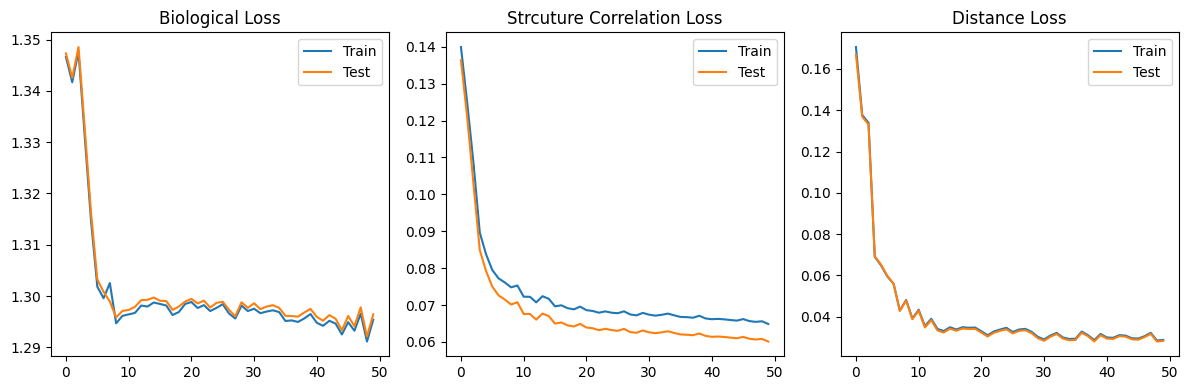

Training epochs:  51%|█████     | 51/100 [4:55:51<4:37:40, 340.01s/it]

Epoch 051 | Train B: 1.2967 S: 0.0650 D: 0.0277 | Test  B: 1.2978 S: 0.0601 D: 0.0271 | ✔️ Improved | Time: 339.9s


Training epochs:  52%|█████▏    | 52/100 [5:01:30<4:31:38, 339.56s/it]

Epoch 052 | Train B: 1.2959 S: 0.0666 D: 0.0291 | Test  B: 1.2970 S: 0.0618 D: 0.0288 |  | Time: 338.5s


Training epochs:  53%|█████▎    | 53/100 [5:07:09<4:25:52, 339.42s/it]

Epoch 053 | Train B: 1.2955 S: 0.0646 D: 0.0254 | Test  B: 1.2962 S: 0.0598 D: 0.0249 | ✔️ Improved | Time: 339.1s


Training epochs:  54%|█████▍    | 54/100 [5:12:49<4:20:18, 339.54s/it]

Epoch 054 | Train B: 1.2957 S: 0.0643 D: 0.0264 | Test  B: 1.2964 S: 0.0595 D: 0.0259 | ✔️ Improved | Time: 339.8s


Training epochs:  55%|█████▌    | 55/100 [5:18:29<4:14:48, 339.74s/it]

Epoch 055 | Train B: 1.2957 S: 0.0639 D: 0.0252 | Test  B: 1.2966 S: 0.0591 D: 0.0247 | ✔️ Improved | Time: 340.2s


Training epochs:  56%|█████▌    | 56/100 [5:24:09<4:09:08, 339.73s/it]

Epoch 056 | Train B: 1.2979 S: 0.0653 D: 0.0283 | Test  B: 1.2986 S: 0.0605 D: 0.0278 |  | Time: 339.7s


Training epochs:  57%|█████▋    | 57/100 [5:29:48<4:03:21, 339.56s/it]

Epoch 057 | Train B: 1.2967 S: 0.0634 D: 0.0251 | Test  B: 1.2975 S: 0.0586 D: 0.0245 | ✔️ Improved | Time: 339.2s


Training epochs:  58%|█████▊    | 58/100 [5:35:27<3:57:38, 339.50s/it]

Epoch 058 | Train B: 1.2964 S: 0.0637 D: 0.0241 | Test  B: 1.2974 S: 0.0588 D: 0.0235 |  | Time: 339.3s


Training epochs:  59%|█████▉    | 59/100 [5:41:09<3:52:28, 340.21s/it]

Epoch 059 | Train B: 1.2964 S: 0.0633 D: 0.0258 | Test  B: 1.2973 S: 0.0584 D: 0.0252 | ✔️ Improved | Time: 341.9s
Epoch 060 | Train B: 1.2979 S: 0.0632 D: 0.0253 | Test  B: 1.2989 S: 0.0584 D: 0.0248 |  | Time: 340.8s


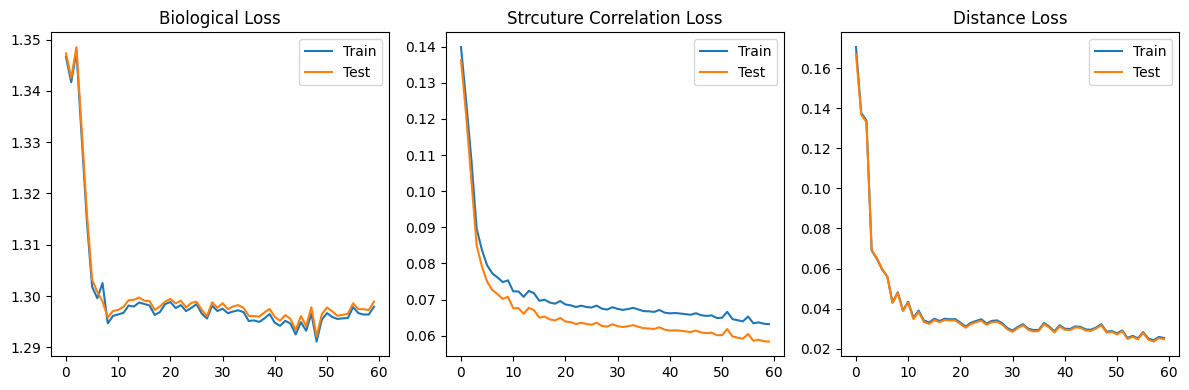

Training epochs:  61%|██████    | 61/100 [5:52:32<3:41:30, 340.79s/it]

Epoch 061 | Train B: 1.2976 S: 0.0632 D: 0.0271 | Test  B: 1.2982 S: 0.0584 D: 0.0265 |  | Time: 341.5s


Training epochs:  62%|██████▏   | 62/100 [5:58:11<3:35:30, 340.28s/it]

Epoch 062 | Train B: 1.2975 S: 0.0627 D: 0.0242 | Test  B: 1.2981 S: 0.0578 D: 0.0237 | ✔️ Improved | Time: 339.1s


Training epochs:  63%|██████▎   | 63/100 [6:03:49<3:29:28, 339.68s/it]

Epoch 063 | Train B: 1.2982 S: 0.0623 D: 0.0236 | Test  B: 1.2990 S: 0.0575 D: 0.0231 | ✔️ Improved | Time: 338.3s


Training epochs:  64%|██████▍   | 64/100 [6:09:29<3:23:50, 339.73s/it]

Epoch 064 | Train B: 1.2971 S: 0.0623 D: 0.0237 | Test  B: 1.2976 S: 0.0575 D: 0.0232 | ✔️ Improved | Time: 339.8s


Training epochs:  65%|██████▌   | 65/100 [6:15:10<3:18:26, 340.19s/it]

Epoch 065 | Train B: 1.2975 S: 0.0621 D: 0.0255 | Test  B: 1.2980 S: 0.0572 D: 0.0249 |  | Time: 341.3s


Training epochs:  66%|██████▌   | 66/100 [6:20:50<3:12:42, 340.07s/it]

Epoch 066 | Train B: 1.2977 S: 0.0626 D: 0.0247 | Test  B: 1.2984 S: 0.0578 D: 0.0241 |  | Time: 339.8s


Training epochs:  67%|██████▋   | 67/100 [6:26:31<3:07:07, 340.23s/it]

Epoch 067 | Train B: 1.2990 S: 0.0625 D: 0.0240 | Test  B: 1.2996 S: 0.0577 D: 0.0235 |  | Time: 340.6s


Training epochs:  68%|██████▊   | 68/100 [6:32:11<3:01:27, 340.22s/it]

Epoch 068 | Train B: 1.2986 S: 0.0621 D: 0.0267 | Test  B: 1.2994 S: 0.0573 D: 0.0260 |  | Time: 340.2s


Training epochs:  69%|██████▉   | 69/100 [6:37:51<2:55:46, 340.22s/it]

Epoch 069 | Train B: 1.3003 S: 0.0624 D: 0.0257 | Test  B: 1.3012 S: 0.0576 D: 0.0251 |  | Time: 340.2s
Epoch 070 | Train B: 1.2987 S: 0.0622 D: 0.0235 | Test  B: 1.2994 S: 0.0573 D: 0.0229 |  | Time: 341.5s


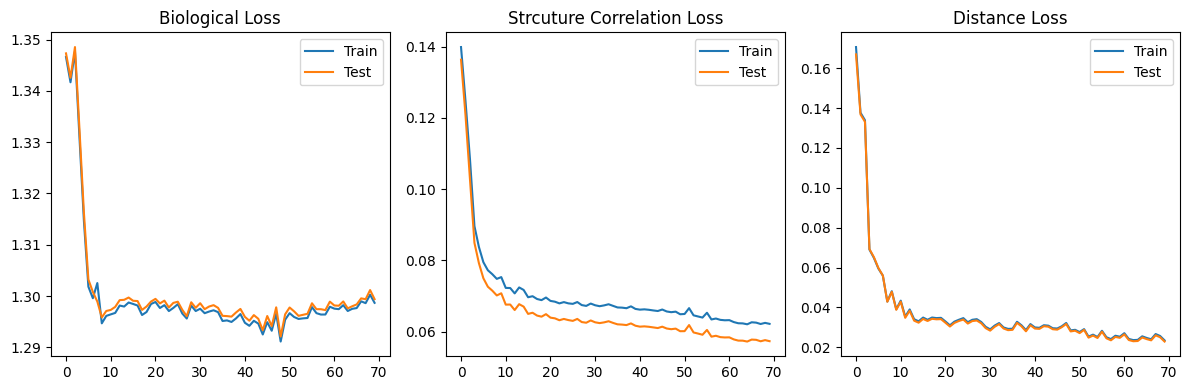

Training epochs:  71%|███████   | 71/100 [6:49:13<2:44:37, 340.62s/it]

Epoch 071 | Train B: 1.2986 S: 0.0618 D: 0.0234 | Test  B: 1.2993 S: 0.0569 D: 0.0228 | ✔️ Improved | Time: 340.4s


Training epochs:  72%|███████▏  | 72/100 [6:54:57<2:39:21, 341.47s/it]

Epoch 072 | Train B: 1.2985 S: 0.0618 D: 0.0232 | Test  B: 1.2993 S: 0.0569 D: 0.0227 | ✔️ Improved | Time: 343.5s


Training epochs:  73%|███████▎  | 73/100 [7:00:40<2:33:57, 342.12s/it]

Epoch 073 | Train B: 1.2986 S: 0.0616 D: 0.0232 | Test  B: 1.2993 S: 0.0567 D: 0.0226 | ✔️ Improved | Time: 343.6s


Training epochs:  74%|███████▍  | 74/100 [7:06:23<2:28:18, 342.23s/it]

Epoch 074 | Train B: 1.2984 S: 0.0615 D: 0.0243 | Test  B: 1.2991 S: 0.0566 D: 0.0237 |  | Time: 342.5s


Training epochs:  75%|███████▌  | 75/100 [7:12:05<2:22:31, 342.08s/it]

Epoch 075 | Train B: 1.2987 S: 0.0623 D: 0.0215 | Test  B: 1.2994 S: 0.0574 D: 0.0209 |  | Time: 341.7s


Training epochs:  76%|███████▌  | 76/100 [7:17:47<2:16:49, 342.06s/it]

Epoch 076 | Train B: 1.2979 S: 0.0616 D: 0.0237 | Test  B: 1.2989 S: 0.0567 D: 0.0231 |  | Time: 342.0s


Training epochs:  77%|███████▋  | 77/100 [7:23:28<2:11:04, 341.94s/it]

Epoch 077 | Train B: 1.2982 S: 0.0615 D: 0.0237 | Test  B: 1.2987 S: 0.0566 D: 0.0232 | ✔️ Improved | Time: 341.7s


Training epochs:  78%|███████▊  | 78/100 [7:29:09<2:05:12, 341.47s/it]

Epoch 078 | Train B: 1.2984 S: 0.0615 D: 0.0248 | Test  B: 1.2992 S: 0.0566 D: 0.0242 |  | Time: 340.4s


Training epochs:  79%|███████▉  | 79/100 [7:34:48<1:59:20, 340.97s/it]

Epoch 079 | Train B: 1.2979 S: 0.0616 D: 0.0219 | Test  B: 1.2986 S: 0.0567 D: 0.0213 | ✔️ Improved | Time: 339.8s
Epoch 080 | Train B: 1.2987 S: 0.0620 D: 0.0230 | Test  B: 1.2990 S: 0.0571 D: 0.0224 |  | Time: 339.4s


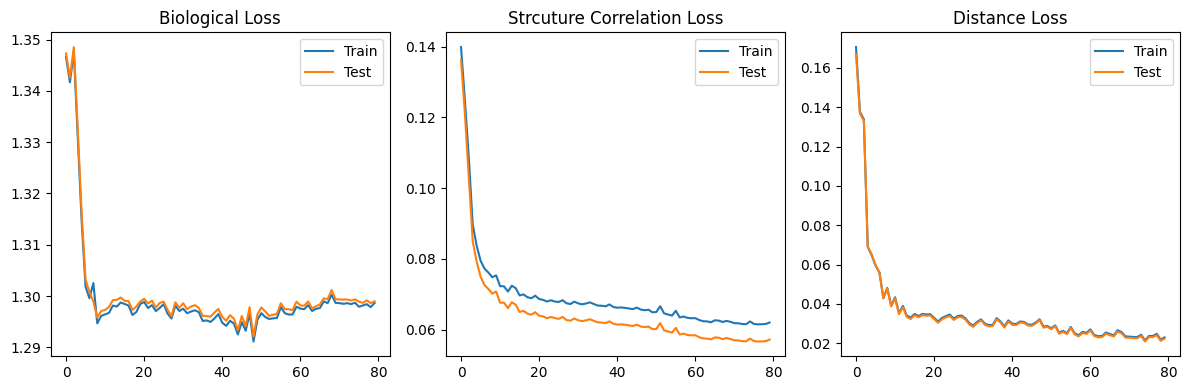

Training epochs:  81%|████████  | 81/100 [7:46:07<1:47:43, 340.17s/it]

Epoch 081 | Train B: 1.2976 S: 0.0615 D: 0.0242 | Test  B: 1.2981 S: 0.0567 D: 0.0236 |  | Time: 339.2s


Training epochs:  82%|████████▏ | 82/100 [7:51:47<1:42:02, 340.14s/it]

Epoch 082 | Train B: 1.2976 S: 0.0613 D: 0.0231 | Test  B: 1.2983 S: 0.0565 D: 0.0225 | ✔️ Improved | Time: 340.1s


Training epochs:  83%|████████▎ | 83/100 [7:57:27<1:36:17, 339.86s/it]

Epoch 083 | Train B: 1.2982 S: 0.0612 D: 0.0234 | Test  B: 1.2989 S: 0.0564 D: 0.0228 |  | Time: 339.2s


Training epochs:  84%|████████▍ | 84/100 [8:03:06<1:30:35, 339.74s/it]

Epoch 084 | Train B: 1.2978 S: 0.0612 D: 0.0236 | Test  B: 1.2982 S: 0.0563 D: 0.0230 | ✔️ Improved | Time: 339.5s


Training epochs:  85%|████████▌ | 85/100 [8:08:45<1:24:50, 339.38s/it]

Epoch 085 | Train B: 1.2979 S: 0.0614 D: 0.0246 | Test  B: 1.2984 S: 0.0565 D: 0.0240 |  | Time: 338.5s


Training epochs:  86%|████████▌ | 86/100 [8:14:24<1:19:11, 339.41s/it]

Epoch 086 | Train B: 1.2980 S: 0.0612 D: 0.0245 | Test  B: 1.2987 S: 0.0564 D: 0.0239 |  | Time: 339.5s


Training epochs:  87%|████████▋ | 87/100 [8:20:04<1:13:34, 339.57s/it]

Epoch 087 | Train B: 1.2979 S: 0.0611 D: 0.0234 | Test  B: 1.2984 S: 0.0563 D: 0.0228 | ✔️ Improved | Time: 339.9s


Training epochs:  88%|████████▊ | 88/100 [8:25:44<1:07:55, 339.61s/it]

Epoch 088 | Train B: 1.2973 S: 0.0615 D: 0.0234 | Test  B: 1.2977 S: 0.0566 D: 0.0229 |  | Time: 339.7s


Training epochs:  89%|████████▉ | 89/100 [8:31:25<1:02:22, 340.18s/it]

Epoch 089 | Train B: 1.2969 S: 0.0615 D: 0.0223 | Test  B: 1.2974 S: 0.0567 D: 0.0217 |  | Time: 341.5s
Epoch 090 | Train B: 1.2971 S: 0.0612 D: 0.0231 | Test  B: 1.2980 S: 0.0564 D: 0.0225 | ✔️ Improved | Time: 340.9s


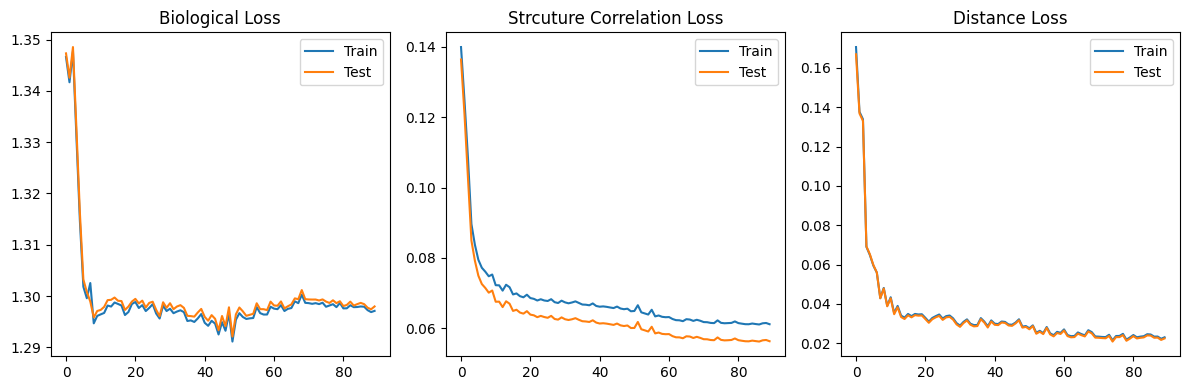

Training epochs:  91%|█████████ | 91/100 [8:42:46<51:02, 340.32s/it]

Epoch 091 | Train B: 1.2973 S: 0.0610 D: 0.0219 | Test  B: 1.2979 S: 0.0561 D: 0.0214 | ✔️ Improved | Time: 339.9s


Training epochs:  92%|█████████▏| 92/100 [8:48:27<45:21, 340.24s/it]

Epoch 092 | Train B: 1.2976 S: 0.0612 D: 0.0243 | Test  B: 1.2982 S: 0.0563 D: 0.0237 |  | Time: 340.0s


Training epochs:  93%|█████████▎| 93/100 [8:54:09<39:46, 340.86s/it]

Epoch 093 | Train B: 1.2960 S: 0.0610 D: 0.0212 | Test  B: 1.2966 S: 0.0562 D: 0.0207 | ✔️ Improved | Time: 342.3s


Training epochs:  94%|█████████▍| 94/100 [8:59:50<34:05, 340.92s/it]

Epoch 094 | Train B: 1.2980 S: 0.0609 D: 0.0236 | Test  B: 1.2985 S: 0.0561 D: 0.0231 |  | Time: 341.1s


Training epochs:  95%|█████████▌| 95/100 [9:05:29<28:21, 340.31s/it]

Epoch 095 | Train B: 1.2967 S: 0.0617 D: 0.0222 | Test  B: 1.2971 S: 0.0569 D: 0.0216 |  | Time: 338.9s


Training epochs:  96%|█████████▌| 96/100 [9:11:09<22:40, 340.14s/it]

Epoch 096 | Train B: 1.2969 S: 0.0610 D: 0.0231 | Test  B: 1.2973 S: 0.0562 D: 0.0225 |  | Time: 339.7s


Training epochs:  97%|█████████▋| 97/100 [9:16:47<16:59, 339.67s/it]

Epoch 097 | Train B: 1.2974 S: 0.0610 D: 0.0232 | Test  B: 1.2980 S: 0.0561 D: 0.0227 |  | Time: 338.6s


Training epochs:  98%|█████████▊| 98/100 [9:22:27<11:19, 339.81s/it]

Epoch 098 | Train B: 1.2963 S: 0.0611 D: 0.0235 | Test  B: 1.2970 S: 0.0562 D: 0.0229 |  | Time: 340.1s


Training epochs:  99%|█████████▉| 99/100 [9:28:05<05:39, 339.12s/it]

Epoch 099 | Train B: 1.2973 S: 0.0610 D: 0.0232 | Test  B: 1.2977 S: 0.0562 D: 0.0226 |  | Time: 337.5s
Epoch 100 | Train B: 1.2961 S: 0.0609 D: 0.0228 | Test  B: 1.2965 S: 0.0561 D: 0.0223 |  | Time: 339.4s


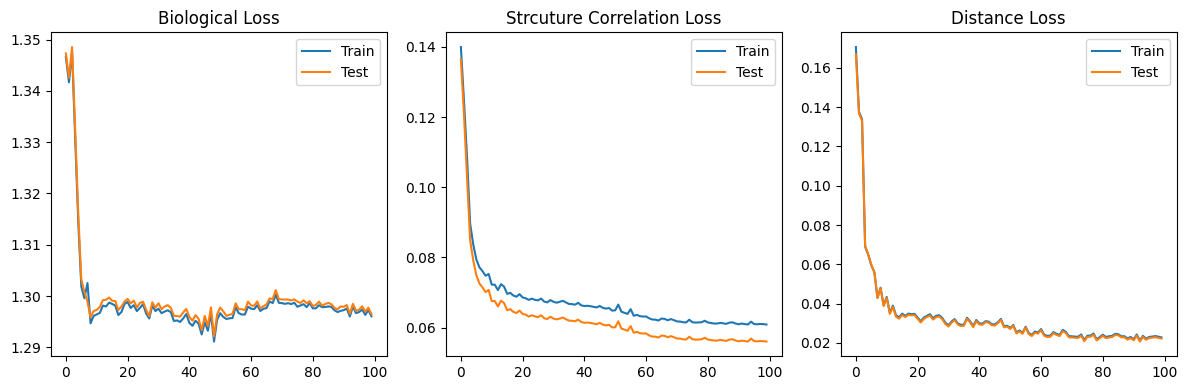

Training epochs: 100%|██████████| 100/100 [9:33:45<00:00, 344.25s/it]


In [ ]:
# Loss function weights
LAMBDA_BIOLOGICAL = 0.75   # 1.5
LAMBDA_STRUCT = 5       # 2.5
LAMBDA_REPEL = 0
LAMBDA_SCALE  = 0   # small scale supervision

best_val_loss   = float('inf')
patience_counter= 0
train_bio_hist  = []
train_struct_hist  = []
train_dist_hist = []
test_bio_hist   = []
test_struct_hist   = []
test_dist_hist  = []


for epoch in tqdm(range(1, NB_EPOCHS+1), desc="Training epochs"):
    t0 = time.time()
    model.train()
    # one epoch train
    for batch in train_loader:
        optimizer.zero_grad()
        hic  = batch['hic'].to(device)
        ts   = batch['struct'].squeeze(1).to(device)
        td   = batch['dist'].squeeze(1).to(device)

        ps, pd = model(hic)
        l_bio  = biological_loss_fct(ps, pd)
        # l_kab  = kabsch_loss_fct(ps, ts)
        l_struc = structure_correlation_loss(ps, ts)
        l_dist = distance_loss_fct(torch.nan_to_num(pd,nan=0.0,posinf=1e6,neginf=-1e6),
                                   torch.nan_to_num(td,nan=0.0,posinf=1e6,neginf=-1e6))

        # repulsion term: only off‐diagonal distances
        B, N, _ = pd.shape
        # make a mask for off‐diagonals
        eye     = torch.eye(N, device=pd.device).bool().unsqueeze(0)  # [1,N,N]
        offdiag = pd.masked_fill(eye, 0.0)                           # zeros on diag
        sum_off = offdiag.sum(dim=(1,2))                            # [B]
        count_off = N*(N-1)                                         # number of off‐diag entries
        mean_off = sum_off / count_off                              # [B]
        l_repel   = (1.0 / (mean_off + 1e-6)).mean()                # scalar

        # scale loss: match average predicted distance to true distance
        # pred_dist pd: [B,N,N], true td: [B,N,N]
        mean_pd = pd.mean(dim=(1,2))          # [B]
        mean_td = td.mean(dim=(1,2))          # [B]
        l_scale = torch.mean((mean_pd - mean_td)**2)

        # loss   = LAMBDA_BIOLOGICAL*l_bio + LAMBDA_KABSCH*l_kab + l_dist + LAMBDA_REPEL * l_repel + LAMBDA_SCALE * l_scale
        loss   = LAMBDA_BIOLOGICAL*l_bio + l_dist + LAMBDA_STRUCT*l_struc

        # loss = LAMBDA_BIOLOGICAL * l_bio
        # if epoch > 5:
        #   loss += LAMBDA_STRUCT*l_struc+ l_dist           #LAMBDA_REPEL * l_repel + LAMBDA_SCALE * l_scale
        # if epoch > 10:
        #   loss += LAMBDA_BIOLOGICAL * l_bio

        loss.backward()
        optimizer.step()

    # evaluate train & test
    train_bio, train_struct, train_dist = evaluate(train_loader, model, device)
    test_bio,  test_struct,  test_dist  = evaluate(test_loader,  model, device)

    train_bio_hist.append(train_bio)
    train_struct_hist.append(train_struct)
    train_dist_hist.append(train_dist)
    test_bio_hist.append(test_bio)
    test_struct_hist.append(test_struct)
    test_dist_hist.append(test_dist)

    current_val = LAMBDA_BIOLOGICAL*test_bio + LAMBDA_STRUCT*test_struct + test_dist
    improved   = current_val < best_val_loss
    if improved:
        best_val_loss = current_val
        torch.save(model.state_dict(), BEST_MODEL_PATH)
        patience_counter = 0
    else:
        patience_counter += 1

    # save every SAVE_INTERVAL epochs
    if epoch % SAVE_INTERVAL == 0 or epoch == NB_EPOCHS:
        torch.save(model.state_dict(),
                   os.path.join(CHECKPOINT_DIR, f'model_epoch_{epoch}.pt'))

    # log
    print(
        f"Epoch {epoch:03d} | "
        f"Train B: {train_bio:.4f} S: {train_struct:.4f} D: {train_dist:.4f} | "
        f"Test  B: {test_bio:.4f} S: {test_struct:.4f} D: {test_dist:.4f} | "
        f"{'✔️ Improved' if improved else ''} | "
        f"Time: {time.time() - t0:.1f}s"
    )

    # live plot every SAVE_INTERVAL
    if epoch % SAVE_INTERVAL == 0 or epoch == NB_EPOCHS:
        plt.figure(figsize=(12,4))
        plt.subplot(1,3,1)
        plt.plot(train_bio_hist, label='Train')
        plt.plot(test_bio_hist,  label='Test')
        plt.title('Biological Loss'); plt.legend()
        plt.subplot(1,3,2)
        plt.plot(train_struct_hist, label='Train')
        plt.plot(test_struct_hist,  label='Test')
        plt.title('Strcuture Correlation Loss');   plt.legend()
        plt.subplot(1,3,3)
        plt.plot(train_dist_hist, label='Train')
        plt.plot(test_dist_hist,  label='Test')
        plt.title('Distance Loss'); plt.legend()
        plt.tight_layout()
        plt.show()

    # early stopping
    if patience_counter >= PATIENCE:
        print(f"Early stopping at epoch {epoch}.")
        break

    # **Step the LR scheduler once per epoch**
    scheduler.step()
    # scheduler.step(current_val)

## Load best model

In [ ]:
BEST_MODEL_PATH = os.path.join(CHECKPOINT_DIR, 'best_model.pt')
model.load_state_dict(torch.load(BEST_MODEL_PATH))
print("✅ Training finished. Best combined val loss:", best_val_loss)

NameError: name 'best_val_loss' is not defined

## Plot final loss trajectory

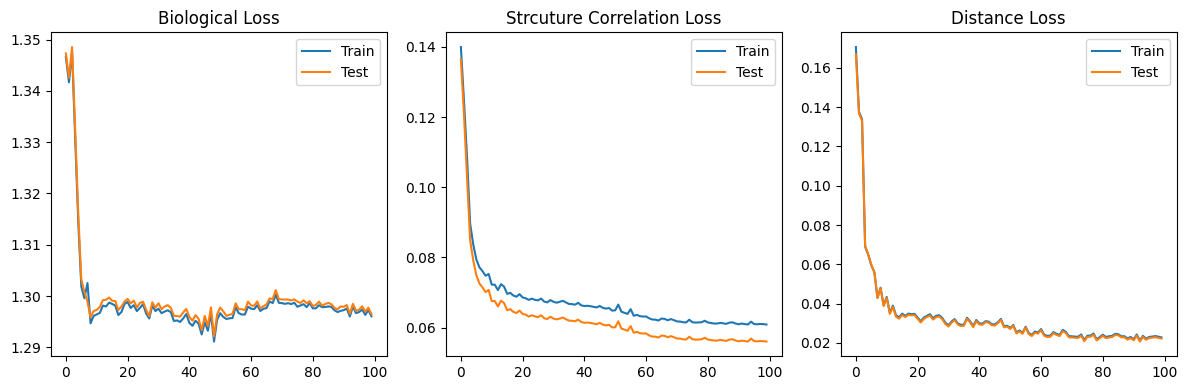

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.plot(train_bio_hist, label='Train')
plt.plot(test_bio_hist,  label='Test')
plt.title('Biological Loss'); plt.legend()
plt.subplot(1,3,2)
plt.plot(train_struct_hist, label='Train')
plt.plot(test_struct_hist,  label='Test')
plt.title('Strcuture Correlation Loss');   plt.legend()
plt.subplot(1,3,3)
plt.plot(train_dist_hist, label='Train')
plt.plot(test_dist_hist,  label='Test')
plt.title('Distance Loss'); plt.legend()
plt.tight_layout()
plt.show()

## Evaluation

### Evaluate with test set (ground truth structure known)

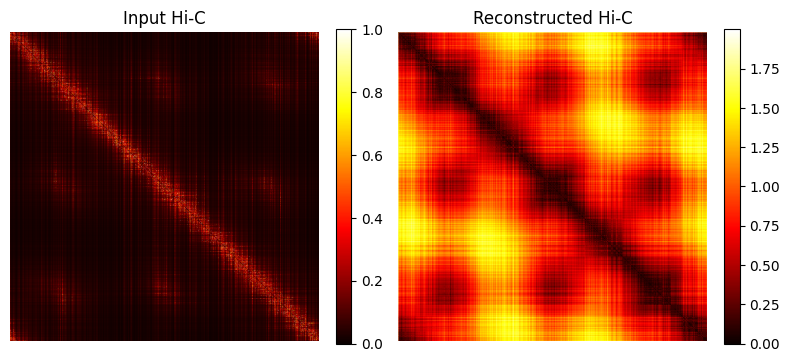

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from plotly.subplots import make_subplots
import plotly.graph_objects as go
def predict_structure_from_hic(
        hic_path,                # .npy Hi‑C file
        true_structure_path,     # .npy true 3‑D coords  (NB_BINS × 3)
        model_path,              # saved weights .pt
        model_class,             # eg. Net
        nb_bins,                 # 928
        device='cuda' if torch.cuda.is_available() else 'cpu'):


    # load and scale Hi‑C
    hic_map = np.load(hic_path)
    assert hic_map.shape == (nb_bins, nb_bins)
    hic_scaled = MinMaxScaler().fit_transform(hic_map)

    hic_tensor = torch.FloatTensor(hic_scaled).unsqueeze(0).to(device)

    # load model
    model = model_class().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    # predict
    with torch.no_grad():
        pred_structure, pred_distance = model(hic_tensor)

    pred_structure = pred_structure.squeeze(0).cpu().numpy()      # (N,3)
    pred_distance  = pred_distance.squeeze(0).cpu().numpy()       # (N,N)

    # true structure
    true_structure = np.load(true_structure_path)                 # (N,3)
    assert true_structure.shape == (nb_bins, 3)

    # plot Hi‑C map
    fig_hic, axes = plt.subplots(1, 2, figsize=(8, 4))
    im0 = axes[0].imshow(hic_scaled, cmap='hot', vmin=0, vmax=1)
    axes[0].set_title('Input Hi‑C')
    im1 = axes[1].imshow(pred_distance, cmap='hot')
    axes[1].set_title('Reconstructed Hi‑C')
    for ax in axes: ax.axis('off')
    cbar0 = plt.colorbar(im0, ax=axes[0], fraction=.046)
    cbar1 = plt.colorbar(im1, ax=axes[1], fraction=.046)
    plt.tight_layout()
    plt.show()

    # plot 3D structure
    fig = make_subplots(
        rows=1, cols=2,
        specs=[[{'type':'scatter3d'}, {'type':'scatter3d'}]],
        horizontal_spacing=0.02
    )

    # True
    fig.add_trace(go.Scatter3d(
        x=true_structure[:,0], y=true_structure[:,1], z=true_structure[:,2],
        mode='lines+markers',
        marker=dict(size=4, color=np.arange(nb_bins), colorscale='hsv'),
        line=dict(color='darkblue', width=2),
        name='True'
    ), row=1, col=1)

    # Predicted
    fig.add_trace(go.Scatter3d(
        x=pred_structure[:,0], y=pred_structure[:,1], z=pred_structure[:,2],
        mode='lines+markers',
        marker=dict(size=4, color=np.arange(nb_bins), colorscale='hsv'),
        line=dict(color='darkblue', width=2),
        name='Predicted'
    ), row=1, col=2)

    fig.update_layout(
        height=600, width=900,
        scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z'),
        scene2=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z'),
        title_text='True vs Predicted 3‑D Structures'
    )
    fig.show()

    return pred_structure, pred_distance

# Call the function with best model
pred_struct, pred_dist = predict_structure_from_hic(
    hic_path              = '/content/drive/MyDrive/STATS507/TECH3D/test/hic_matrices/synthetic_ecoli_hic_00007.npy',
    true_structure_path   = '/content/drive/MyDrive/STATS507/TECH3D/test/structure_matrices/synthetic_ecoli_structure_00007.npy',
    model_path            = '/content/drive/MyDrive/STATS507/TECH3D/model/checkpoints/06/best_model.pt',
    model_class           = Net,
    nb_bins               = 928
)

## Predcition with experimental HiC map

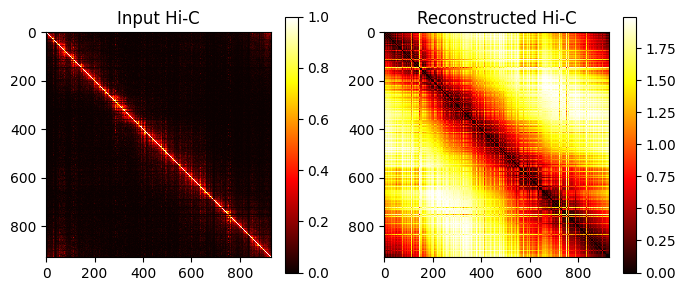

In [ ]:
#  Load the matrix
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import pandas as pd
matrix_path = '/content/drive/MyDrive/STATS507/HiC_dataset/GSM2870407_mat_BC70_TACT_wt_MM_30C.txt'
hic_df = pd.read_csv(matrix_path, sep='\t', index_col=0)
# Drop extra column if it exists
hic_df = hic_df.loc[:, ~hic_df.columns.str.contains('^Unnamed')]


# Ensure it's symmetric (Hi-C should be)
assert hic_df.shape[0] == hic_df.shape[1], "Matrix must be square"
assert all(hic_df.columns == hic_df.index), "Matrix must have same row and column labels"

# Convert to numpy array
hic_raw = hic_df.values.astype(np.float32)


def matrix_norm(matrix, method="minmax"):
    from sklearn.preprocessing import MinMaxScaler

    if method == "minmax":
        scaler = MinMaxScaler()
        return scaler.fit_transform(matrix)

    elif method == "log":
        return np.log1p(matrix)

    elif method == "distance":
        N = matrix.shape[0]
        log_matrix = np.log1p(matrix)
        dist = np.abs(np.subtract.outer(np.arange(N), np.arange(N)))
        mean_by_dist = np.array([
            log_matrix[dist == d].mean() if np.any(dist == d) else 1.0
            for d in range(N)
        ])
        norm = np.array([
            log_matrix[i] / mean_by_dist[np.abs(i - np.arange(N))]
            for i in range(N)
        ])
        return np.nan_to_num(norm)

    elif method == "none":
        return matrix

    else:
        raise ValueError(f"Unknown normalization method: {method}")


# Normalize with preferred method

hic_map = matrix_norm(hic_raw, method="minmax")

model_path='/content/drive/MyDrive/STATS507/TECH3D/model/checkpoints/06/best_model.pt'
model_class=Net

hic_tensor = torch.FloatTensor(hic_map).unsqueeze(0).to(device)  # shape: (1, nb_bins, nb_bins)

# Load model
model = model_class().to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

# Predict
with torch.no_grad():
    pred_structure, pred_distance = model(hic_tensor)

pred_structure = pred_structure.squeeze(0).cpu().numpy()  # shape: (nb_bins, 3)
pred_distance = pred_distance.squeeze(0).cpu().numpy()    # shape: (nb_bins, nb_bins)

# Plot: Input vs Predicted Distance Map
fig, axes = plt.subplots(1, 2, figsize=(7,3))

im = axes[0].imshow(hic_map, cmap='hot', interpolation='nearest', vmin=0, vmax=1)

im = axes[1].imshow(pred_distance, cmap='hot', interpolation='nearest')

axes[0].set_title("Input Hi-C")
axes[1].set_title("Reconstructed Hi-C")

plt.colorbar(axes[0].images[0], ax=axes[0])
plt.colorbar(axes[1].images[0], ax=axes[1])
plt.tight_layout()
plt.show()


# Initialize figure with 3D subplots
x_pred, y_pred, z_pred = pred_structure[:, 0], pred_structure[:, 1], pred_structure[:, 2]
fig = make_subplots(
    rows=1, cols=1,
    specs=[[{'type': 'scatter3d'}]])

# adding surfaces to subplots.
fig.add_trace(
    go.Scatter3d(
    x=x_pred, y=y_pred, z=z_pred,
    marker=dict(
        size=5,
        color=np.asarray(range(len(x_pred))),
        colorscale='hsv',
    ),
    line=dict(
        color='darkblue',
        width=2
    )
), row=1, col=1)

fig.update_layout(
    height=500,
    width=500
)

fig.update_layout(
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'
    )
)

fig.show()

## Save predicted structure

In [ ]:
matrix_name = 'GSM2870407_mat_BC70_TACT_wt_MM_30C.txt'
np.savetxt('tech3d_'+matrix_name, pred_structure, delimiter='\t')
# save to local
from google.colab import files
files.download('tech3d_'+matrix_name)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>